In [ ]:
/content/drive/MyDrive/cryptopunks

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !ls
import os
paths = os.chdir("/content/drive/MyDrive/cryptopunks")

print(paths)

None


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs 


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from skimage.measure import block_reduce
import time
from IPython import display
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import glob
import imageio

In [ ]:
image_sizes = {"cryptopunks": (32, 32)}
batch_size = 75

In [ ]:
# Preprocessing the datasets for Keras usability
def get_data(collection):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        collection,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_sizes["cryptopunks"],
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        collection,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_sizes["cryptopunks"],
        batch_size=batch_size,
    )
    return train_ds, val_ds


train_ds, val_ds = get_data("/content/drive/MyDrive/cryptopunks")

# Normalizing pixel values between [-1, 1] 
def process(image,label):
    image = tf.cast((image - 127.5)/127.5 ,tf.float32)
    return image,label

train_ds = train_ds.map(process)

Found 2845 files belonging to 2 classes.
Using 2276 files for training.
Found 2845 files belonging to 2 classes.
Using 569 files for validation.


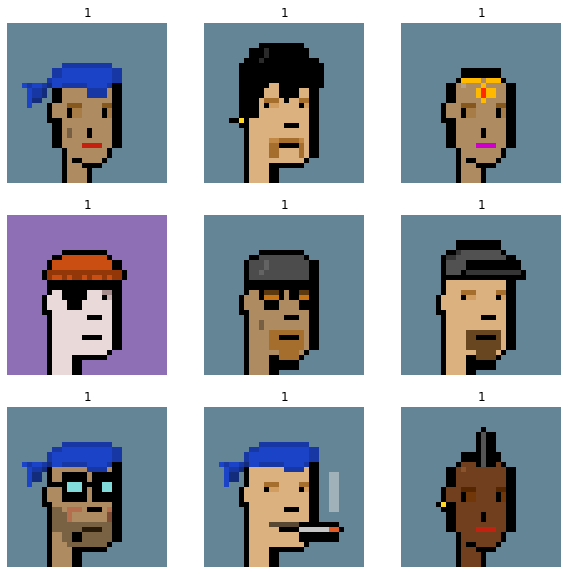

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((127.5 + 127.5*images[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=100)
val_ds = val_ds.prefetch(buffer_size=100)

In [ ]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Final output should be of shape (32, 32, 3 (RGB))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

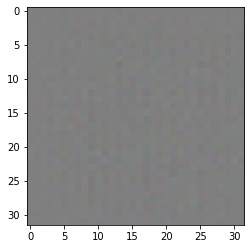

In [ ]:
# Creating model
generator = make_generator_model()

# Length 100 noise vector
noise = tf.random.normal([1, 100])

# Passing noise through untrained generator dataset
generated_image = generator(noise, training=False)

%matplotlib inline
plt.imshow((127.5 + 127.5*generated_image[0, :, :, :].numpy()).astype("uint8"), cmap='viridis')

In [ ]:
def make_discriminator_model():
    
    # Be sure to define the input shape as the same as the shape of the training dataset images
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Final layer is 1 neuron, returning the probability the image is real
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Creating discriminator model
discriminator = make_discriminator_model()

# Passing the noise image through the generator
decision = discriminator(generated_image)

# Getting the decision, expect a very small value because the image is simple noise
print (decision)

tf.Tensor([[0.00144367]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Some global variables for the training process
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
# i.e. the gif will use the same generated images, just after every epoch
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    # Generating noise vector
    noise = tf.random.normal([batch_size, noise_dim]) # Batch_size defined in dataset creation

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generating image with the noise vector
        generated_images = generator(noise, training=True)

        # Passing the image and the generated image through the discriminator model
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculating the loss for the generator and discriminator respectively
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculating the gradients for each model
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Applying the gradients to the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, labels in dataset:
            # Grab every batch of images and train the model on them
            train_step(image_batch)

        # Produce images for the GIF as you go at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate image after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # training is set to False so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((127.5+predictions[i, :, :, :]*127.5).numpy().astype("uint8"), cmap='viridis')
        plt.axis('off')

    plt.savefig('./epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

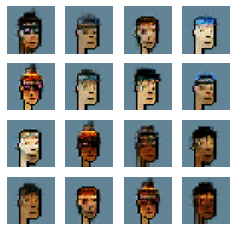

AttributeError: ignored

In [ ]:
# Train on the training dataset for 200 Epochs
num_epochs = 200

train(train_ds, num_epochs)

train_ds.shape

In [ ]:

def getDate(collection):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        collection,
        validation_split=0.2,
        subset="training",
        seed=1337,
        # image_size=image_sizes[collection],
        #batch_size=batch_size,
  )

getDate("/content/drive/MyDrive/cryptopunks")

Found 2845 files belonging to 2 classes.
Using 2276 files for training.
